In [1]:
import tensorflow as tf
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# 检查 TensorFlow 版本
print("TensorFlow version:", tf.__version__)

# 列出所有可用的物理设备
print("Physical devices:", tf.config.list_physical_devices())

# 检查是否有可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPU found. TensorFlow is using CPU.")

TensorFlow version: 2.6.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [2]:
## import package
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
import pandas as pd

### Build up basic model


In [3]:
import tensorflow as tf

def create_model(input_shape, num_classes, centers):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Hidden Layers
    filter_sizes = [40, 20, 10, 20, 10, 30, 18, 18]
    kernel_sizes = [11, 1, 11, 1, 1, 11, 1, 3]
    x = inputs
    for filters, kernel_size in zip(filter_sizes, kernel_sizes):
        x = tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)

    # Max Pooling Layer
    x = tf.keras.layers.MaxPooling1D(3)(x)

    # Flatten Layer
    x = tf.keras.layers.Flatten()(x)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(input_shape[0], activation='sigmoid', name='classification_output')(x)
    classification_output = tf.keras.layers.Reshape((input_shape[0], 1), name='reshape')(classification_output)
    
    # Regression Layer for area
    area_output = tf.keras.layers.Dense(len(centers), name='area_output')(x)
    
    # Regression Layer for sigma
    sigma_output = tf.keras.layers.Dense(len(centers), name='sigma_output')(x)
    
    # Model
    model = tf.keras.models.Model(inputs=inputs, outputs=[classification_output, area_output, sigma_output])

    return model

# 示例调用
input_shape = (100, 1)  # 输入形状 (100, 1)
num_classes = 2  # 假设有2个类别
centers = [20, 30, 40, 60, 70]  # 假设有5个中心

model = create_model(input_shape, num_classes, centers)
model.summary()

# 查看模型结构
print("Classification output shape:", model.output[0].shape)
print("Regression output shape:", model.output[1].shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 10)      2210        conv1d_1[0][0]                   
______________________________________________________________________________________________

2025-01-09 15:53:19.062209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 15:53:20.452705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46350 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:16:00.0, compute capability: 8.6
2025-01-09 15:53:20.453450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46716 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:34:00.0, compute capability: 8.6
2025-01-09 15:53:20.453923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device

## Train the model

In [4]:
def compile_model(model):
    # 使用Adam优化器，学习率为0.002
    optimizer = optimizers.Adam(learning_rate=0.002)
    
    # 为每个输出指定一个损失函数
    losses = {
        'reshape': 'binary_crossentropy',  # 二元分类任务使用交叉熵损失函数
        'area_output': 'mean_squared_error',  # 回归任务（area）使用均方误差损失函数
        'sigma_output': 'mean_squared_error'  # 回归任务（sigma）使用均方误差损失函数
    }
    
    # 为每个输出指定一个评估指标
    metrics = {
        'reshape': 'accuracy',  # 二元分类任务使用准确率作为评估指标
        'area_output': tf.keras.metrics.MeanSquaredError(),  # 回归任务（area）使用均方误差作为评估指标
        'sigma_output': tf.keras.metrics.MeanSquaredError()  # 回归任务（sigma）使用均方误差作为评估指标
    }
    
    # 设置损失权重，增加 sigma_output 的权重
    loss_weights = {
        'reshape': 1.0,
        'area_output': 1.0,
        'sigma_output': 2.0  # 增加 sigma_output 的权重
    }
    
    
    # 编译模型
    model.compile(optimizer=optimizer, loss=losses, metrics=metrics, loss_weights=loss_weights)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
# 使用较小的批次大小，避免内存不足

def train_classification_model(model, X_train, y_train_classification, y_train_area, y_train_sigma, X_val, y_val_classification, y_val_area, y_val_sigma):
    # 确保 y_train_classification 的形状为 (batch_size, 100, 1)
    # 使用较小的批次大小，避免内存不足
    batch_size = len(X_train)

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    history = model.fit(X_train, [y_train_classification, y_train_area, y_train_sigma], 
                        epochs=4000, 
                        batch_size=batch_size, 
                        validation_data=(X_val, [y_val_classification, y_val_area, y_val_sigma]),
                        callbacks=[early_stopping])
                       
    return history




In [6]:
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_val, y_val_classification, y_val_area, y_val_sigma, scaler_area, scaler_sigma):
    # 预测验证集
    y_pred_classification, y_pred_area, y_pred_sigma = model.predict(X_val)
    print(f'y_pred_classification shape: {y_pred_classification.shape}')
    print(f'y_pred_area shape: {y_pred_area.shape}')
    print(f'y_pred_sigma shape: {y_pred_sigma.shape}')
    
    # 逆标准化预测的 area 和 sigma
    y_pred_area = scaler_area.inverse_transform(y_pred_area)
    y_pred_sigma = scaler_sigma.inverse_transform(y_pred_sigma)
    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    # 打印调试信息
    print("Debugging Information:")
    print(f'y_val_classification shape: {y_val_classification.shape}, y_val_classification dtype: {y_val_classification.dtype}')
    print(f'y_pred_classes shape: {y_pred_classes.shape}, y_pred_classes dtype: {y_pred_classes.dtype}')
    
    # 确保 y_val_classification 和 y_pred_classes 的形状一致
    y_val_classes = y_val_classification
    
    # 展开为一维数组
    y_val_classes_flat = y_val_classes.flatten()
    y_pred_classes_flat = y_pred_classes.flatten()
    
    # 打印分类报告
    print("Classification Report:")
    class_report = classification_report(y_val_classes_flat, y_pred_classes_flat, output_dict=True)
    print(classification_report(y_val_classes_flat, y_pred_classes_flat))
    
    # 将分类报告转换为 DataFrame 并写入 CSV 文件
    classification_df = pd.DataFrame(class_report).transpose()
    classification_df.to_csv('classification_report.csv', index=True)
    
    # 回归评估
    # 打印调试信息以检查形状
    print(f'y_val_area shape: {y_val_area.shape}')
    print(f'y_pred_area shape: {y_pred_area.shape}')
    print(f'y_val_sigma shape: {y_val_sigma.shape}')
    print(f'y_pred_sigma shape: {y_pred_sigma.shape}')
    
    # 分别计算 area 和 sigma 的评估指标
    for name, y_val, y_pred in zip(['area', 'sigma'], [y_val_area, y_val_sigma], [y_pred_area, y_pred_sigma]):
        y_val_flat = y_val.flatten()
        y_pred_flat = y_pred.flatten()
        
        mse = mean_squared_error(y_val_flat, y_pred_flat)
        mae = mean_absolute_error(y_val_flat, y_pred_flat)
        r2 = r2_score(y_val_flat, y_pred_flat)
        
        print(f"Regression Evaluation for {name}:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R^2 Score: {r2}")
        
        # 将回归评估结果写入 CSV 文件
        regression_report = {
            'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R^2 Score'],
            f'{name}': [mse, mae, r2]
        }
        regression_df = pd.DataFrame(regression_report)
        regression_df.to_csv(f'{name}_regression_report.csv', index=False)
    
    # 查看具体的sigma预测情况
    print("\nDetailed Sigma Predictions:")
    for i in range((len(y_val_sigma)//1000)):
        print(f"Sample {i+1}:")
        print(f"True Sigma: {y_val_sigma[i]}")
        print(f"Predicted Sigma: {y_pred_sigma[i]}")
        print(f"True Area: {y_val_area[i]}")
        print(f"Predicted Area: {y_pred_area[i]}")
        print()
    
    # 计算绝对误差和相对误差
    absolute_errors = (y_val_sigma - y_pred_sigma)
    relative_errors = ((y_val_sigma - y_pred_sigma) / y_val_sigma)

    # 计算绝对误差中绝对值小于等于0.2的个数
    count = 0
    print_count = 0

    # 初始化 area 差值的上下界
    min_area_diff = float('inf')
    max_area_diff = float('-inf')

    for i in range(len(absolute_errors)):
        for j in range(len(absolute_errors[i])):
            if abs(absolute_errors[i][j]) <= 0.2:
                count += 1
                print_count += 1
                if print_count >= 25:
                    break
                # 打印真实和预测的 sigma 和 area
                print(f"Sample {i}, Index {j}:")
                print(f"True Sigma: {y_val_sigma[i][j]}")
                print(f"Predicted Sigma: {y_pred_sigma[i][j]}")
                print(f"True Area: {y_val_area[i][j]}")
                print(f"Predicted Area: {y_pred_area[i][j]}")
                print()
                
                # 计算 area 的差值，并更新上下界
                area_diff = y_val_area[i][j] - y_pred_area[i][j]
                min_area_diff = min(min_area_diff, area_diff)
                max_area_diff = max(max_area_diff, area_diff)

    print("绝对误差小于等于0.2的个数：", count)

    # 打印 area 差值的上下界
    print("Area Difference Bounds:")
    print(f"Min: {min_area_diff}")
    print(f"Max: {max_area_diff}")
    # 计算统计信息
    def print_statistics(data, name):
        max_val = np.max(data)
        min_val = np.min(data)
        std_dev = np.std(data)
        avg = np.mean(data)
        median = np.median(data)
        mean = np.mean(data)

        print(f"{name} Statistics:")
        print(f"Max: {max_val}")
        print(f"Min: {min_val}")
        print(f"Standard Deviation: {std_dev}")
        print(f"Average: {avg}")
        print(f"Median: {median}")
        print(f"Mean: {mean}")
        print()

    # 打印绝对误差的统计信息
    print_statistics(absolute_errors, "Absolute Error")

    # 打印相对误差的统计信息
    print_statistics(relative_errors, "Relative Error")

    # 绘制箱型图
    plt.figure(figsize=(12, 6))

    # 绝对误差的箱型图
    plt.subplot(1, 2, 1)
    plt.boxplot(absolute_errors.flatten())
    plt.title("Absolute Error Box Plot")
    plt.ylabel("Absolute Error")

    # 计算上下界和异常值数量
    q1, q3 = np.percentile(absolute_errors.flatten(), [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = absolute_errors.flatten()[(absolute_errors.flatten() < lower_bound) | (absolute_errors.flatten() > upper_bound)]
    print("Absolute Error Box Plot:")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Outliers: {len(outliers)}")
    print(f"Percentage of Outliers: {len(outliers) / len(absolute_errors.flatten()) * 100}%")
    print()

    # 相对误差的箱型图
    plt.subplot(1, 2, 2)
    plt.boxplot(relative_errors.flatten())
    plt.title("Relative Error Box Plot")
    plt.ylabel("Relative Error")

    # 计算上下界和异常值数量
    q1, q3 = np.percentile(relative_errors.flatten(), [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = relative_errors.flatten()[(relative_errors.flatten() < lower_bound) | (relative_errors.flatten() > upper_bound)]
    print("Relative Error Box Plot:")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Outliers: {len(outliers)}")
    print(f"Percentage of Outliers: {len(outliers) / len(relative_errors.flatten()) * 100}%")

    plt.show()




def get_regression_values_for_class1(model, X_val, centers, y_val_regression):
    # 得到预测值
    y_pred_classification, y_pred_regression = model.predict(X_val)
    
    final_output = []
    final_validation = []

    final_output_for_plot = []
    final_validation_for_plot = []

    class1_indices_per_sample = []  # 新增的列表来存储每个样本中被分类为 class 1 的索引

    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    for i in range(len(y_pred_classes)):
        # 获取分类输出中值为1的索引
        indices = np.where(y_pred_classes[i] == 1)[0]
        
        # 记录这些索引
        class1_indices_per_sample.append(indices)

        # 对每个分类输出值为1的索引，计算它与所有中心的距离
        distances = np.abs(indices.reshape(-1, 1) - np.array(centers).reshape(1, -1))

        # 找到最近的中心
        closest_center_indices = np.argmin(distances, axis=1)

        # 为每个分类输出值为1的索引返回对应的回归值
        for idx in closest_center_indices:
            final_output.append(y_pred_regression[i][idx].tolist())
            final_validation.append(y_val_regression[i][idx].tolist())

        # 为plot存数据
        final_output_for_plot.append(y_pred_regression[i, closest_center_indices])
        final_validation_for_plot.append(y_val_regression[i, closest_center_indices])

    return np.array(final_output), np.array(final_validation), np.array(final_output_for_plot, dtype=object), np.array(final_validation_for_plot, dtype=object), class1_indices_per_sample

In [7]:
Training_areas = [[0,1,5,50,95,100],[0,1,5,50,95,100,200],[0,1,5,50,95,200,300],[0,1,5,50,95,300,400],[0,1,5,50,95,400,500],[0,1,5,50,95,500,600],[0,1,5,50,95,600,700],[0,1,5,50,95,700,800],[0,1,5,50,95,800,900],[0,1,5,50,95,900,1000]]
Training_areas_new = []

# 更改训练数据的分位数区间
for areas in Training_areas:
    max_area = areas[-1]  # 获取当前区间的最大值
    # 创建新的四分位数区间，并四舍五入到最接近的整数
    new_areas = [round(val) for val in [0, 0.2*max_area, 0.5*max_area, 0.8*max_area, max_area]]
    Training_areas_new.append(new_areas)

print(Training_areas_new)

[[0, 20, 50, 80, 100], [0, 40, 100, 160, 200], [0, 60, 150, 240, 300], [0, 80, 200, 320, 400], [0, 100, 250, 400, 500], [0, 120, 300, 480, 600], [0, 140, 350, 560, 700], [0, 160, 400, 640, 800], [0, 180, 450, 720, 900], [0, 200, 500, 800, 1000]]


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-09 15:54:02.620402: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1293"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 312500
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = A

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1


2025-01-09 15:54:07.978380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-09 15:54:08.731221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-09 15:54:09.399778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-09 15:54:09.808650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-09 15:54:11.528240: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - ETA: 0s - loss: 3.7019 - reshape_loss: 0.6955 - area_output_loss: 0.9954 - sigma_output_loss: 1.0055 - reshape_accuracy: 0.4763 - area_output_mean_squared_error: 0.9954 - sigma_output_mean_squared_error: 1.0055

2025-01-09 15:54:15.192238: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_9654"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

1/1 [==============================] - 14s 14s/step - loss: 3.7019 - reshape_loss: 0.6955 - area_output_loss: 0.9954 - sigma_output_loss: 1.0055 - reshape_accuracy: 0.4763 - area_output_mean_squared_error: 0.9954 - sigma_output_mean_squared_error: 1.0055 - val_loss: 3.6149 - val_reshape_loss: 0.6862 - val_area_output_loss: 0.9818 - val_sigma_output_loss: 0.9734 - val_reshape_accuracy: 0.6168 - val_area_output_mean_squared_error: 0.9818 - val_sigma_output_mean_squared_error: 0.9734
Epoch 2/4000
1/1 [==============================] - 1s 590ms/step - loss: 3.6147 - reshape_loss: 0.6862 - area_output_loss: 0.9807 - sigma_output_loss: 0.9739 - reshape_accuracy: 0.6171 - area_output_mean_squared_error: 0.9807 - sigma_output_mean_squared_error: 0.9739 - val_loss: 3.5392 - val_reshape_loss: 0.6766 - val_area_output_loss: 0.9684 - val_sigma_output_loss: 0.9471 - val_reshape_accuracy: 0.7412 - val_area_output_mean_squared_error: 0.9684 - val_sigma_output_mean_squared_error: 0.9471
Epoch 3/4000
1

2025-01-09 15:57:26.665589: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_175401"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

y_pred_classification shape: (160000, 100, 1)
y_pred_area shape: (160000, 4)
y_pred_sigma shape: (160000, 4)
Debugging Information:
y_val_classification shape: (160000, 100), y_val_classification dtype: float64
y_pred_classes shape: (160000, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00  15488000
         1.0       1.00      0.97      0.98    512000

    accuracy                           1.00  16000000
   macro avg       1.00      0.98      0.99  16000000
weighted avg       1.00      1.00      1.00  16000000

y_val_area shape: (160000, 4)
y_pred_area shape: (160000, 4)
y_val_sigma shape: (160000, 4)
y_pred_sigma shape: (160000, 4)
Regression Evaluation for area:
Mean Squared Error (MSE): 10.32492894954301
Mean Absolute Error (MAE): 2.3192828755519868
R^2 Score: 0.9927999100770272
Regression Evaluation for sigma:
Mean Squared Error (MSE): 2.3390435386971813
Mean Absolute Err

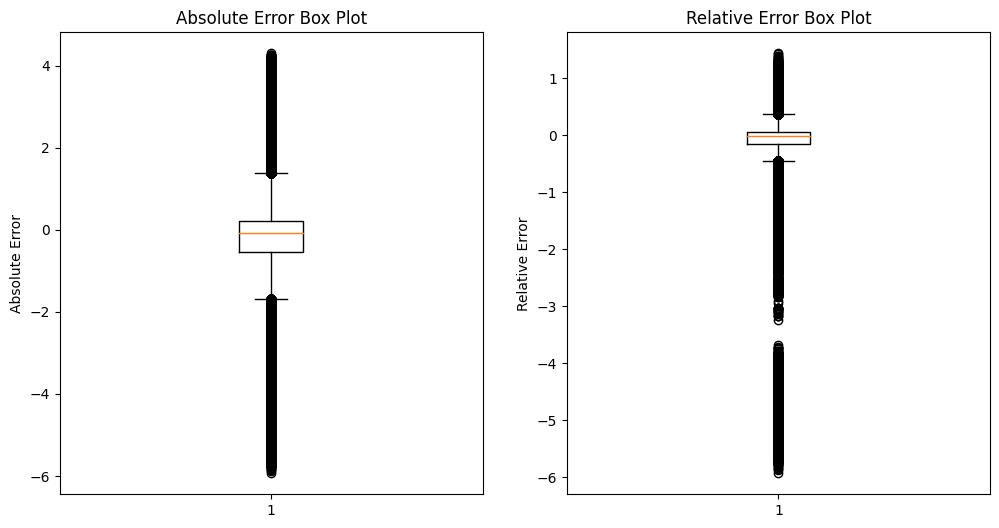

In [8]:
from tensorflow.keras import backend as K
import Failuer_file.Generate_sig_area as Generate_sig_area
from sklearn.model_selection import train_test_split


centers = [20, 30, 40, 60]
sigma = [1,4,6,8,10]
noise_level = 1/300 
Training_areas =[0,20, 50, 80, 100]
Testing_areas = [0, 10, 25, 55, 105]
Test_sigma = [1,3,7,9]

K.clear_session()
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # 设置输入形状和类别数量
    input_shape = (100,1)  # 示例输入形状
    num_classes = 2  # 假设有2个类别

    # 创建模型
    model = create_model(input_shape, num_classes,centers)
    model.summary()

    # 编译模型
    compile_model(model)

# 加载和预处理数据
# 从 train_data.xlsx 中加载数据
X_train, y_train_classification, y_train_area, y_train_sigma = Generate_sig_area.generate_data(centers, Training_areas, sigma, noise_level, x_size=100)


# 划分训练集和验证集
X_train, X_val, y_train_classification, y_val_classification, y_train_area, y_val_area, y_train_sigma, y_val_sigma = train_test_split(
    X_train, y_train_classification, y_train_area, y_train_sigma, test_size=0.2)


# 从 test_data.xlsx 中加载数据（如果有相同的结构）
X_test, y_test_classification, y_test_area, y_test_sigma = Generate_sig_area.generate_data(centers, Testing_areas, Test_sigma, noise_level, x_size=100)
# 创建 StandardScaler 对象
scaler_area = StandardScaler()
scaler_sigma = StandardScaler()

# 对训练集的 area 和 sigma 进行标准化
y_train_area = scaler_area.fit_transform(y_train_area)
y_train_sigma = scaler_sigma.fit_transform(y_train_sigma)

# 对验证集的 area 和 sigma 进行标准化
y_val_area = scaler_area.transform(y_val_area)
y_val_sigma = scaler_sigma.transform(y_val_sigma)


# 训练模型
history = train_classification_model(model, X_train, y_train_classification, y_train_area, y_train_sigma, X_val, y_val_classification, y_val_area, y_val_sigma)


# 评估模型
evaluate_model(model, X_test, y_test_classification, y_test_area, y_test_sigma, scaler_area, scaler_sigma)



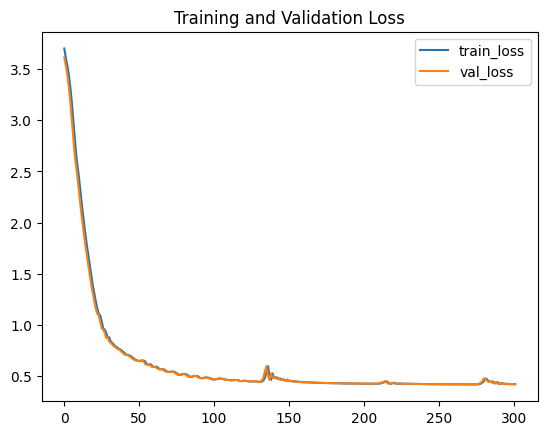

In [9]:
# 查看训练和验证损失
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

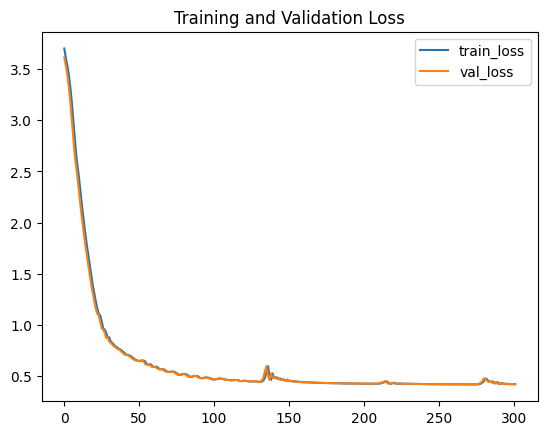

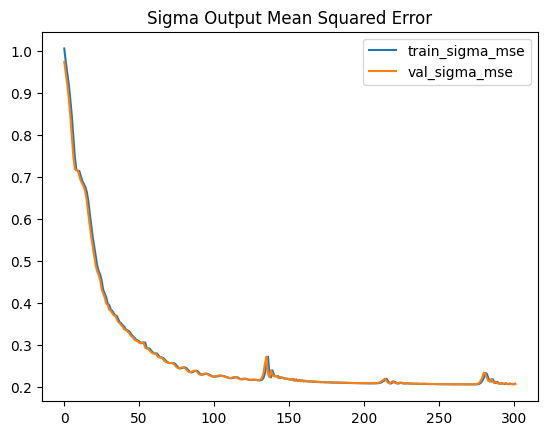

In [10]:
# 绘制训练和验证损失曲线
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# 绘制 sigma_output 的 MSE 曲线
plt.figure()
plt.plot(history.history['sigma_output_mean_squared_error'], label='train_sigma_mse')
plt.plot(history.history['val_sigma_output_mean_squared_error'], label='val_sigma_mse')
plt.legend()
plt.title("Sigma Output Mean Squared Error")
plt.show()

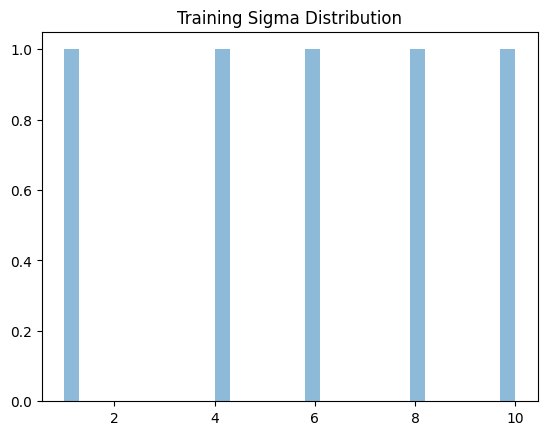

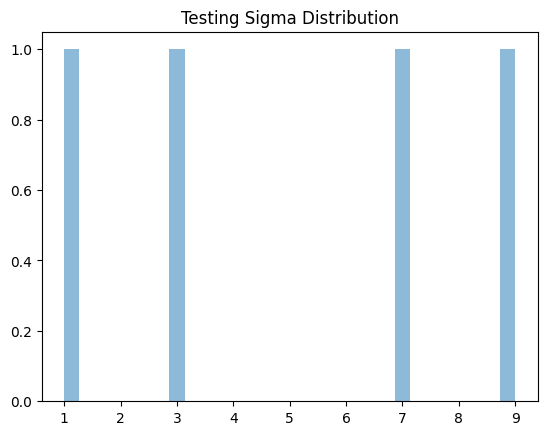

In [11]:
def plot_data_distribution(data, title):
    plt.figure()
    plt.hist(data.flatten(), bins=30, alpha=0.5)
    plt.title(title)
    plt.show()

# 查看 sigma 的数据分布
plot_data_distribution(np.array(sigma), "Training Sigma Distribution")
plot_data_distribution(np.array(Test_sigma), "Testing Sigma Distribution")